In [1]:
import read_data_utils as utils
import regression_weight_tuning_EU_LG_UA as EU_LG_UA
import reorganization as reorg
import cramming as cr

In [2]:
import sys
import copy
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
file = 'train_all_0.csv'
dataloaders, dataset_sizes = utils.read_data(file, batch_size=8, mode='mse')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class slfn(nn.Module):
    def __init__(self, p):
        super(slfn, self).__init__()
        self.l1 = nn.Linear(12,p)
        self.l2 = nn.Linear(p,1)
    def forward(self, x):
        out = F.relu(self.l1(x))
        out = self.l2(out)
        return out
    
class slfn2(nn.Module):
    def __init__(self, p):
        super(slfn, self).__init__()
        self.l1 = nn.Linear(12,p)
        self.l2 = nn.Linear(p,1)
    def forward(self, x):
        out = F.relu(self.l1(x))
        
        out = self.l2(out)
        return out

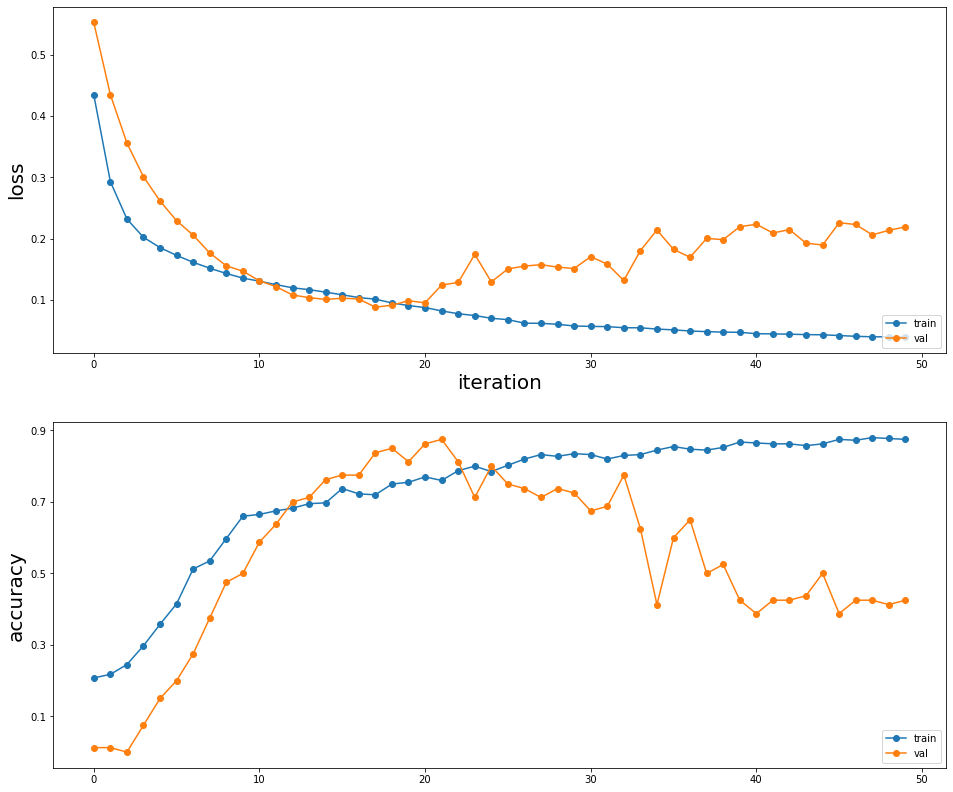

<Figure size 288x288 with 0 Axes>

Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: 1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, 

In [5]:
# model = nn.Sequential(
#       nn.Linear(12,50),
#       nn.ReLU(),
#       nn.Linear(50,1)).to(device)
model = slfn(50).to(device)

# model.load_state_dict(torch.load('../acceptable_weights/before_reorg.pt'))

criterion = nn.MSELoss()

train_result = EU_LG_UA.train_model_lgt1(model, criterion, dataloaders, dataset_sizes, device,
                                    PATH = '../weights/train_checkpoint.pt', 
                                    epsilon = 1e-6, num_epochs=50, lgep = 0.3, show=True)

# train_result = EU_LG_UA.train_model_lsc(model, criterion, dataloaders, dataset_sizes, device,
#                                     PATH = '../weights/train_checkpoint.pt', 
#                                     epsilon = 1e-6, num_epochs=50, n=1, show=True, v=0.6)

torch.save(model.state_dict(), '../acceptable_weights/before_reorg.pt')

if train_result['result']:
    print('Acceptable SLFN')
    torch.save(model.state_dict(), '../acceptable_weights/before_reorg.pt')
#     model.load_state_dict(torch.load('../acceptable_weights/before_reorg.pt'))
    reorg_result, p = reorg.reorg_model(model, criterion, dataloaders, dataset_sizes, train_result['v'],device, 
                                      PATH='../weights/reorg_checkpoint.pt', lr_epsilon=1e-6 , n=1, rs=0.1)
    print(reorg_result, p)
    torch.save(model.state_dict(), f'../acceptable_weights/after_reorganized_{p}.pt')
else:
    # cramming
    ua_cases = cr.get_unacceptable_lgt1(model, dataloaders, train_result['ep'])
    print('Unacceptable SLFN (', train_result['msg'],')')
    print(ua_cases)
    print(len(ua_cases))

In [7]:
params = cr.cram_lgt1(model, dataloaders, train_result['ep'], zeta = 1e-3)

Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 0.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 1.0
Pred: -1.0, Label: 0.0
Pred: -1.0,

Meet case...
G: tensor([[0.0590],
        [0.0585],
        [0.3215],
        [0.3340],
        [0.5881],
        [0.2286],
        [0.1575],
        [0.4159],
        [0.1338],
        [0.3984],
        [0.0740],
        [0.0155]]), Case: tensor([-0.8424, -0.4693, -2.0732, -1.2637, -0.0325,  0.1563, -0.9116, -0.2017,
         0.0795, -0.0468,  1.4265, -0.1987])
Meet case...
G: tensor([[0.1832],
        [0.3577],
        [0.0074],
        [0.2049],
        [0.5753],
        [0.1481],
        [0.3219],
        [0.3340],
        [0.2104],
        [0.1859],
        [0.3273],
        [0.2060]]), Case: tensor([ 0.1662, -0.0428,  0.5879,  0.5069, -1.2015, -1.2111,  0.4168,  0.1236,
        -1.2163, -0.8653, -0.2924, -0.4407])
Meet case...
G: tensor([[0.1096],
        [0.0632],
        [0.4515],
        [0.2572],
        [0.0300],
        [0.3499],
        [0.2906],
        [0.0994],
        [0.3015],
        [0.4565],
        [0.4434],
        [0.0214]]), Case: tensor([-0.9311, -1.3629,  0.3

Meet case...
G: tensor([[0.2462],
        [0.3753],
        [0.3372],
        [0.0854],
        [0.2949],
        [0.4017],
        [0.2930],
        [0.2409],
        [0.0281],
        [0.3317],
        [0.1135],
        [0.4020]]), Case: tensor([ 1.6669,  1.5719,  2.2078, -1.8969, -1.1470, -1.1724,  1.1940, -0.6572,
        -1.1934, -0.8583, -0.1156, -0.3009])
Meet case...
G: tensor([[0.1048],
        [0.2233],
        [0.1953],
        [0.0978],
        [0.5263],
        [0.3874],
        [0.2324],
        [0.3830],
        [0.2248],
        [0.3550],
        [0.1371],
        [0.2614]]), Case: tensor([-1.1167, -1.0380, -0.5662,  0.8976,  0.0669,  0.2565, -0.9116, -0.4620,
         0.3681, -0.0576, -0.8234, -0.2151])
Meet case...
G: tensor([[0.3295],
        [0.0524],
        [0.2576],
        [0.3263],
        [0.2004],
        [0.0178],
        [0.3688],
        [0.3573],
        [0.1828],
        [0.3902],
        [0.4156],
        [0.2308]]), Case: tensor([ 1.4975,  1.3586,  0.9

In [7]:
# params = cr.cram_lsc(model, dataloaders, train_result['v'], train_result['one_min'], train_result['zero_max'], zeta = 1e-3)

In [8]:
for k in params.keys():
    print(k, ' ', params[k].shape, type(params[k]))
p = params['l1.weight'].shape[0]
p

l1.weight   torch.Size([197, 12]) <class 'torch.Tensor'>
l1.bias   torch.Size([197]) <class 'torch.Tensor'>
l2.weight   torch.Size([1, 197]) <class 'torch.Tensor'>
l2.bias   torch.Size([1]) <class 'torch.Tensor'>


197

In [9]:
modela = slfn(p).to(device)
modela.load_state_dict(params)

<All keys matched successfully>

In [9]:
a = torch.tensor([ 1.6427,  1.5110,  1.8430, -1.1895, -1.1571, -1.1822,  1.2085, -0.1366,
        -1.1962, -0.8584, -0.0779, -0.2962]).to(device)
modela(a.unsqueeze(0))

tensor([[0.2233]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [10]:
ua = []
for u in ua_cases:
    ua.append(u[0].to(device))
uac = 0
modeln = slfn(50).to(device)
modeln.load_state_dict(torch.load('../acceptable_weights/before_reorg.pt'))
def inUA(input):
    for u in ua:
        if torch.equal(input, u):
            return True
    return False

for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    a = modeln(inputs)
    b = modela(inputs)
    for i in range(inputs.shape[0]):  
        if not inUA(inputs[i]):
            print(f"before: {a[i].item():.5f}, after: {b[i].item():.5f}, diff: {b[i].item()-a[i].item():.5f}, label: {labels[i]}")
        else:
            uac += 1
print(uac)

before: 0.93404, after: 0.93423, diff: 0.00020, label: 1.0
before: 0.99112, after: 1.09829, diff: 0.10718, label: 1.0
before: 0.98036, after: 0.98038, diff: 0.00002, label: 1.0
before: 1.03295, after: 1.03262, diff: -0.00033, label: 1.0
before: 1.11930, after: 1.11905, diff: -0.00026, label: 1.0
before: 0.90384, after: 0.90420, diff: 0.00036, label: 1.0
before: 0.25514, after: 0.25656, diff: 0.00142, label: 0.0
before: 1.02014, after: 1.02041, diff: 0.00027, label: 1.0
before: 1.00749, after: 1.00796, diff: 0.00047, label: 1.0
before: 0.90526, after: 0.90640, diff: 0.00114, label: 1.0
before: 0.74835, after: 0.74807, diff: -0.00028, label: 1.0
before: 1.05897, after: 1.05874, diff: -0.00023, label: 1.0
before: 1.08514, after: 1.08474, diff: -0.00039, label: 1.0
before: 0.98789, after: 0.98745, diff: -0.00044, label: 1.0
before: 1.01600, after: 1.01577, diff: -0.00022, label: 1.0
before: 1.00110, after: 0.99942, diff: -0.00168, label: 1.0
before: 1.04521, after: 1.04544, diff: 0.00023, 

before: 1.01215, after: 1.01211, diff: -0.00004, label: 1.0
before: 1.09171, after: 1.09146, diff: -0.00025, label: 1.0
before: 0.96884, after: 0.96914, diff: 0.00030, label: 1.0
before: -0.03932, after: -0.03965, diff: -0.00033, label: 0.0
before: 1.06660, after: 1.06601, diff: -0.00059, label: 1.0
before: 0.82722, after: 0.82705, diff: -0.00017, label: 1.0
before: 0.11455, after: 0.11575, diff: 0.00120, label: 0.0
before: 0.90742, after: 0.90774, diff: 0.00033, label: 1.0
before: 0.03360, after: 0.03409, diff: 0.00049, label: 0.0
before: 1.06333, after: 1.06167, diff: -0.00166, label: 1.0
before: 0.99097, after: 0.99112, diff: 0.00015, label: 1.0
before: 0.90273, after: 0.90298, diff: 0.00025, label: 1.0
before: 0.95061, after: 0.95157, diff: 0.00095, label: 1.0
before: 0.03142, after: 0.03128, diff: -0.00014, label: 0.0
before: 0.22088, after: 0.22171, diff: 0.00083, label: 0.0
before: 0.88531, after: 0.88553, diff: 0.00022, label: 1.0
before: 1.05120, after: 1.05117, diff: -0.00003

before: 1.06733, after: 1.06741, diff: 0.00008, label: 1.0
before: 1.09039, after: 1.09060, diff: 0.00021, label: 1.0
before: 0.88650, after: 0.88662, diff: 0.00012, label: 1.0
before: 0.95938, after: 0.95962, diff: 0.00024, label: 1.0
before: 0.90711, after: 0.90738, diff: 0.00027, label: 1.0
before: 0.79976, after: 0.80008, diff: 0.00032, label: 1.0
before: 0.87102, after: 0.87063, diff: -0.00038, label: 1.0
before: 1.01686, after: 1.01700, diff: 0.00014, label: 1.0
before: 0.91561, after: 0.91641, diff: 0.00080, label: 1.0
before: 0.85405, after: 0.85403, diff: -0.00002, label: 1.0
before: 1.01925, after: 1.01935, diff: 0.00009, label: 1.0
before: 0.07505, after: 0.07510, diff: 0.00005, label: 0.0
before: 0.26140, after: 0.26284, diff: 0.00145, label: 0.0
before: 0.86259, after: 0.86148, diff: -0.00111, label: 1.0
before: 0.90271, after: 0.90310, diff: 0.00039, label: 1.0
before: 1.06213, after: 1.06198, diff: -0.00015, label: 1.0
before: 1.12922, after: 1.12832, diff: -0.00089, lab

In [11]:
ua_cases2 = cr.get_unacceptable_lgt1(modela, dataloaders, train_result['ep'])
ua_cases2

[]